# Table of Contents

* [Introduction](#Introduction)
* [Analysis](#Analysis)
* [Report](#Report)

# Introduction

Author: Alan Lorenzetti  
Date: 01/11/2023  

This script will use two predictors on provided sequences and plot them on a defined region.

* PQSfinder (https://doi.org/10.1093/bioinformatics/btx413)
* QmRLFS-finder (https://doi.org/10.1093/nar/gkv344)

# Analysis

In [1]:
# 01112023 alorenzetti

# description ####
# This script will take the repair hotspot regions
# and SVA information and try to correlate them

# QmRLFS-finder requires
# python2.7

# setting up ####
# loading libs
packs = c(
 "tidyverse",
 "ggbeeswarm",
 "viridis",
 "ggpubr",
 "ggthemes",
 "pqsfinder",
 "Gviz",
 "BSgenome",
 "Biostrings",
 "GenomicRanges",
 "plyranges",
 "rtracklayer"
)

lapply(packs, require, character.only = TRUE)

theme_set(theme_pubr())

# setting working directory relative to _h
setwd("../_m/")

# setting up number of cores
# to use in this script
threads=14

# setting up path
# matching the bin
# in the conda env
# this is necessary
# for R finding
# the required program
conda_env = str_replace(Sys.getenv("R_HOME"), "^.*/(.*)/lib/R$", "\\1")
home = str_replace(Sys.getenv("R_HOME"), "^(.*)/.*/lib/R$", "\\1")
conda_env_path = paste0(home, "/", conda_env, "/bin")
old_path = Sys.getenv("PATH")
Sys.setenv(PATH = paste(old_path, conda_env_path, sep = ":"))

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: ggbeeswarm

Warning message:
“package ‘ggbeeswarm’ was built under R version 4.2.2”
Loading required package: viridis

Loading required package: viridisLite

Loading required package: ggpubr

Loading required package: ggthemes

Warning message:
“package ‘ggthemes’ was built under R version 4.2.1”
Loading required package: pqsfinder

Warning message:
“package ‘pqsfinder’ was built under R version 4.2.2”
Loading required package: Biostrings

Warning message:
“package ‘Biostrings’ was built under R version 4.2.2”
Loading required package: BiocGener

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

In [2]:
# getting started ####
# this function will take a genome
# location to load and parse chr names
read_genome = function(file = file){
    
    genome = readDNAStringSet(filepath = file)
    names(genome) = str_replace(string = names(genome), pattern = " .*$", replacement = "")
    
    return(genome)
    
}

In [3]:
# this function will get four properties
# of regions in a strin
get_coords = function(regions = regions){
    
    res = list()
    
    res$chr = str_replace(string = regions,
                          pattern = "^(.*):.*-.*:.*$",
                          replacement = "\\1")
    
    res$start = str_replace(string = regions,
                            pattern = "^.*:(.*)-.*:.*$",
                            replacement = "\\1") %>% as.numeric()
      
    res$end = str_replace(string = regions,
                          pattern = "^.*:.*-(.*):.*$",
                          replacement = "\\1") %>% as.numeric()
    
    res$strand = str_replace(string = regions,
                             pattern = "^.*:.*-.*:(.*)$",
                             replacement = "\\1")
        
    return(res)
}

In [4]:
# this will create GR objx
# from passed regions in the
# format chrX:start-end:strand
to_gr = function(rois = rois){
    
    coordinates = get_coords(regions = rois)
    
    gr = GRanges(seqnames = coordinates$chr,
                 ranges = IRanges(start = coordinates$start,
                                  end = coordinates$end),
                 strand = coordinates$strand)
    
    names(gr) = rois
    
    return(gr)
    
}

In [5]:
# this function will get filenames from regions
name_from_region = function(regions = regions){
    
    coordinates = get_coords(regions = regions
                            )
    coordinates$strand = str_replace(coordinates$strand, "-", "minus")
    coordinates$strand = str_replace(coordinates$strand, "\\+", "plus")
    
    file_name = paste0(coordinates %>% unlist(), collapse = "_")
    
    return(file_name)
}

In [6]:
# this function is a wrapper for
# the QmRLFS-finder software
# to predict R-loops
# it is going to return a GRanges
# bed obj
run_rloop_pred = function(sequences = sequences){
    
    # getting coords and file name
    coordinates = get_coords(regions = names(sequences))
    file_name = name_from_region(regions = names(sequences))
    
    # writing fasta for the input seq
    writeXStringSet(x = sequences, filepath = paste0(file_name, ".fa"))
    
    # setting commandline
    interpreter = "python2.7"
    program = "QmRLFS-finder.py"
    
    infile = paste("--infile", paste0(file_name, ".fa"))
    outfile = paste("--outfile", paste0(file_name,"_qmrlfs"))
    
    model = "--model m1,m2"
    coordinate = paste("--coordinate", paste0(coordinates$chr, ":",
                                              coordinates$start, "-",
                                              coordinates$end))
    strand = paste("--strand", coordinates$strand)
    formats = paste("-table", "-bed", "-fa")
    
    # defining call
    args = NULL
    args[1] = interpreter
    args[2] = paste(program, infile, outfile, model, coordinate, strand, formats)
    
    # calling program
    system2(command = args[1],
            args = args[2],
            stdout = paste0(file_name, "_qmrlfs_out_out.log"),
            stderr = paste0(file_name, "_qmrlfs_out_err.log"))

    
    # reading results from bed format
    res = rtracklayer::import(con = paste0(file_name, "_qmrlfs.out.bed"),
                              format = "bed")
    
    return(res)
    
}

In [7]:
# this function will take an object of
# sequences with coordinates in their names
# to pass to the pqs predictor
# it will return a list for each sequence with
# results and computed density from pqsfinder
run_pred = function(sequences = sequences){
    
    res = list()
    
    for(name in names(sequences)){
        coordinates = get_coords(regions = name)
        
        res[[name]][["results"]][["plus"]] = pqsfinder(subject = sequences[[name]],
                                             strand = "+",
                                             deep = T,
                                             min_score = 20)
        res[[name]][["results"]][["minus"]] = pqsfinder(subject = sequences[[name]],
                                             strand = "-",
                                             deep = T,
                                             min_score = 20)
        
        
        res[[name]][["density"]][["raw"]][["plus"]] = density(res[[name]][["results"]][["plus"]])
        res[[name]][["density"]][["raw"]][["minus"]] = density(res[[name]][["results"]][["minus"]])
        
        res[[name]][["density"]][["gr"]][["plus"]] = to_gr(rois = paste0(coordinates$chr, ":",
                                                                         coordinates$start + 0:(length(res[[name]][["density"]][["raw"]][["plus"]])-1), "-",
                                                                         coordinates$start + 1:length(res[[name]][["density"]][["raw"]][["plus"]]), ":",
                                                                         "+"))
        res[[name]][["density"]][["gr"]][["minus"]] = to_gr(rois = paste0(coordinates$chr, ":",
                                                                         coordinates$start + 0:(length(res[[name]][["density"]][["raw"]][["minus"]])-1), "-",
                                                                         coordinates$start + 1:length(res[[name]][["density"]][["raw"]][["minus"]]), ":",
                                                                         "-"))
        
        mcols(res[[name]][["density"]][["gr"]][["plus"]])$score = res[[name]][["density"]][["raw"]][["plus"]]
        mcols(res[[name]][["density"]][["gr"]][["minus"]])$score = res[[name]][["density"]][["raw"]][["minus"]]
        res[[name]][["pqs"]][["gr"]] = c(res[[name]][["density"]][["gr"]][["plus"]], res[[name]][["density"]][["gr"]][["minus"]])
        
        res[[name]][["density"]][["tibble"]][["plus"]] = res[[name]][["density"]][["gr"]][["plus"]] %>% as_tibble()
        res[[name]][["density"]][["tibble"]][["minus"]] = res[[name]][["density"]][["gr"]][["minus"]] %>% as_tibble()
        
        res[[name]][["rloop"]][["gr"]] = run_rloop_pred(sequences = sequences[name])
        
    }
    
    return(res)
}


In [8]:
# this function will
# take a scored GR object of
# variable range sizes
# and transform into 1-sized-bin
gr_bin_one = function(gr = gr) {
    
    bin_one = tile_ranges(gr, width = 1)
    
    scores_tib = tibble(partition = as.character(1:length(gr)),
                        score = mcols(gr)$score)
                        
    bin_one_tib = mcols(bin_one) %>% 
        as_tibble() %>% 
        mutate(partition = as.character(partition))
    
    merged = left_join(x = bin_one_tib,
                       y = scores_tib,
                       by = "partition")
    
    mcols(bin_one)$score = merged$score
    mcols(bin_one)$partition = NULL
    
    return(bin_one)
}

In [9]:
# this function will take the genome, an object storing
# predictions and a compatible interval to
# display the region using the Gviz package
plot_gviz = function(genome = genome,
                     data = data,
                     plot_region = plot_region,
                     highlight_region = highlight_region,
                     annot_region = annot_region,
                     annot_text = annot_text,
                     plot_seq = plot_seq){
    
    coordinates = get_coords(regions = plot_region)
    highlight_coordinates = get_coords(regions = highlight_region)
    annot_coordinates = get_coords(regions = annot_region)
    plot_region_gr = to_gr(rois = plot_region)
    
    data$rloop$gr_dens = as(object = coverage(data$rloop$gr[strand(data$rloop$gr) == coordinates$strand]),
                            Class = "GRanges")
    
    seqlengths(data$rloop$gr_dens) = seqlengths(genome)[coordinates$chr]
    
    new_granges_coord = GRanges(seqnames = coordinates$chr,
                                ranges = IRanges(start = end(data$rloop$gr_dens[length(data$rloop$gr_dens)])+1,
                                                 end = end(data$rloop$gr_dens[length(data$rloop$gr_dens)])+width(plot_region_gr)),
                                strand = "*")
    new_granges_coord$score = 0
    
    data$rloop$gr_dens = c(data$rloop$gr_dens, new_granges_coord)
    
    data$rloop$gr_dens_bin_one = subsetByOverlaps(x = data$rloop$gr_dens,
                                                  ranges = plot_region_gr,
                                                  minoverlap = 1)
    data$rloop$gr_dens_bin_one = gr_bin_one(gr = data$rloop$gr_dens_bin_one)
    
    data$pqs$gr = data$pqs$gr[strand(data$pqs$gr) == coordinates$strand]
    
    genome_axis = GenomeAxisTrack(fontcolor = "black")
    
    annot_track =  AnnotationTrack(start = annot_coordinates$start,
                                   end = annot_coordinates$end,
                                   strand = annot_coordinates$strand,
                                   chromosome = annot_coordinates$chr,
                                   id = annot_text,
                                   name = "",
                                   fill = "lightgrey")
    
    data_track_pqs = DataTrack(range = data$pqs$gr,
                               width = 1,
                               chromosome = coordinates$chr,
                               genome = "hg38",
                               name = paste0("PQS dens. (", coordinates$strand, ")"),
                               type = "l",
                               col = "#7b848f",
                               # ylim = c(0, max(mcols(data$rloop$gr_dens_bin_one)$score)),
                               ylim = c(0, 27500))
    
    data_track_rloop = DataTrack(range = data$rloop$gr_dens_bin_one,
                                           width = 1,
                                           chromosome = coordinates$chr,
                                           genome = "hg38",
                                           name = paste0("R-loop dens. (", coordinates$strand, ")"),
                                           type = "l",
                                           col = "#7b848f",
                                           # ylim = c(0, max(mcols(data$rloop$gr_dens_bin_one)$score)),
                                           ylim = c(0, 20))
    
    highlights = HighlightTrack(trackList = list(data_track_pqs, data_track_rloop),
                                start = highlight_coordinates$start, end = highlight_coordinates$end,
                                chromosome = highlight_coordinates$chr)
    
    seqTrack53 = SequenceTrack(sequence = genome,
                               chromosome = coordinates$chr,
                               name = "Sequence",
                               fontcolor = c(A="#59A14F",
                                             C="#4E79A7",
                                             T="#E15759",
                                             G="#F28E2B"),
                               add53 = T)
    
    seqTrack35 = SequenceTrack(sequence = genome,
                               chromosome = coordinates$chr,
                               name = "Sequence",
                               fontcolor = c(A="#59A14F",
                                             C="#4E79A7",
                                             T="#E15759",
                                             G="#F28E2B"),
                               add53 = T,
                               complement = T)
    
    # # annotation track example
    # AnnotationTrack(range = data$rloop$gr,
    #                 name = "Predicted R-loops",
    #                 col = "black",
    #                 fill = "#4E79A7")
    
    if(plot_seq){
        mytracks = list(genome_axis,
                    annot_track,
                    highlights,
                    seqTrack53,
                    seqTrack35)
        
        sizes_vec = c(0.25,0.25,1,1,0.1,0.1)
    } else {
        mytracks = list(genome_axis,
                    annot_track,
                    highlights)
        
        sizes_vec = c(0.25,0.25,1,1)
    }
    
    
    
    p = plotTracks(trackList = mytracks,
                   from = coordinates$start,
                   to = coordinates$end,
                   fontcolor.title = "black",
                   fontface.title = "plain",
                   col.axis = "black",
                   # col.border.title = "black",
                   fontcolor.feature = "black",
                   shape = "box", featureAnnotation = "id",
                   sizes= sizes_vec,
                   background.title = "white")
    
    return(p)
   
}

In [10]:
# main code ####
# obtaining the sequence of interest
# from a known range
# reading the genome
xdp = list()

xdp$genome = read_genome(file = "GRCh38_with_XDP_SVA.primary_assembly.genome.fa")

In [11]:
# my regions of interest to compute PQS
# borrowing some from Taylor's Nanopore
# experiment to test the plotting function
rois = c(
        "chrX:71440000-71444000:+",
        # "chrX:71440513-71443140:+",
        "chrX:71453000-71457000:+"
        # "chr3:133784940-133786232:+",
        # "chr8:64685151-64686184:+",
        # "chr1:174348481-174351069:+",
        # "chr10:70686282-70687322:+",
        # # "chrX:71451480-71453116:+",
        # "chr12:56782661-56784730:+",
        # "chr9:27546546-27573481:+",
        # "chrX:147911919-147951125:+",
        # "chr17:7661779-7676594:+"
        )

xdp$gr = to_gr(rois = rois)

# extract sequence
xdp$seqs = getSeq(x = xdp$genome, xdp$gr)

# predicting G4 using
# pqsfinder
preds = run_pred(sequences = xdp$seqs)

# writing density bedgraphs
# and also sequences used
# to compute them
for(name in names(preds)){
    coordinates = get_coords(regions = name)
    coordinates$strand = str_replace(coordinates$strand, "-", "minus")
    coordinates$strand = str_replace(coordinates$strand, "\\+", "plus")
    
    file_name = paste0(coordinates %>% unlist(), collapse = "_")

    rtracklayer::export.bedGraph(object = preds[[name]]$pqs$gr,
                                 con = paste0(file_name, ".bedgraph"))
    
#    writeXStringSet(x = xdp$seqs[name], filepath = paste0(file_name, ".fa"))
}

In [12]:
#### for dev only ####
# # testing pqs density
# # to learn about interpretation
# ex_seqs = lapply(1:20, function(x) {paste0(rep("GGGGAAA", x), collapse = "")} ) %>% 
#     as.character()

# ex_seqs = DNAStringSet(x = ex_seqs)

# ex_seqs_res = lapply(ex_seqs, function(x) {pqsfinder(x,
#                                                      strand = "+",
#                                                      deep = T,
#                                                      overlapping = T,
#                                                      min_score = 20)})

# ex_seqs_res_dens = lapply(ex_seqs_res, function(x) {density(x)})

# # ex_seqs_res_dens[[3]]
# # give us an example on what is density
# ex_seqs_res[[3]]

# # there is a total of 9 overlapping predictions
# # for the string GGGGAAA GGGGAAA GGGGAAA
# # 21 nt
# ex_seqs_res_dens[[3]]

# #  GGGGAAA GGGGAAA GGGGAAA
# #  1234567 8911111 1111122
# #            01234 5678901

# #1 GGGGAAA GGGGAAA GG
# #2 GGGGAAA GGGGAAA GGG
# #3 GGGGAAA GGGGAAA GGGG
# #4  GGGAAA GGGGAAA GG
# #5  GGGAAA GGGGAAA GGG
# #6  GGGAAA GGGGAAA GGGG
# #7   GGAAA GGGGAAA GG
# #8   GGAAA GGGGAAA GGG
# #9   GGAAA GGGGAAA GGGG

# #  3699999 9999999 9963000
# x =  c(3,6,9,9,9,9,9,9,9,9,9,9,9,9,9,9,6,3,0,0,0)
# # hist(x)
# # plot(density(x))

# Report

## Methods

### Our analysis

# Results

## XDP-associated SVA F

I am plotting the XDP-associated SVA F region.

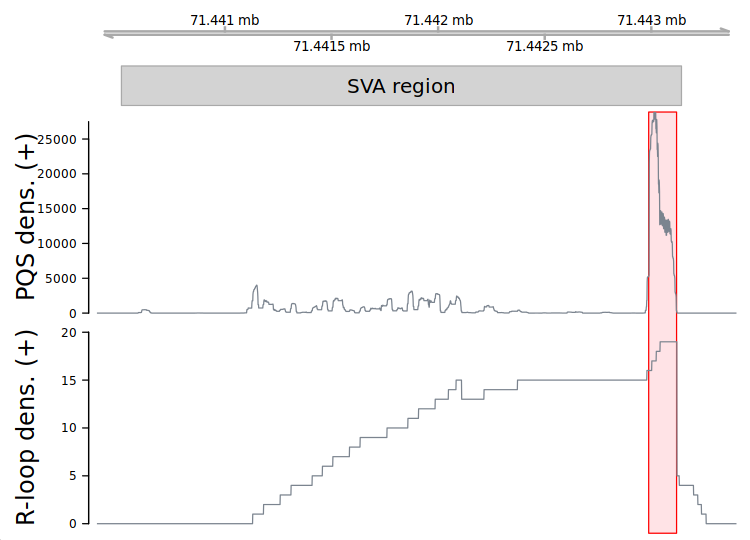

In [13]:
# plotting
options(repr.plot.width = 6.25, repr.plot.height = 4.5)

plots = list()
plots[["chrX:71440000-71444000:+"]] = plot_gviz(genome = xdp$genome,
                                                data = preds$`chrX:71440000-71444000:+`,
                                                plot_region = "chrX:71440400-71443400:+",
                                                highlight_region = "chrX:71442990-71443120:+",
                                                annot_region = "chrX:71440515-71443141:-",
                                                annot_text = "SVA region",
                                                plot_seq = F)

In [14]:
pdf(file = "chrX_71440400_71443400_plus.pdf", width = 6.5, height = 4.5)
plot_gviz(genome = xdp$genome,
          data = preds$`chrX:71440000-71444000:+`,
          plot_region = "chrX:71440400-71443400:+",
          highlight_region = "chrX:71442990-71443120:+",
          annot_region = "chrX:71440515-71443141:-",
          annot_text = "SVA region",
          plot_seq = F)
dev.off()

$Axis
Genome axis 'Axis'

[[2]]
AnnotationTrack ''
| genome: NA
| active chromosome: chrX
| annotation features: 1

$`PQS dens. (+)`
DataTrack 'PQS dens. (+)'
| genome: hg38
| active chromosome: chrX
| positions: 3000
| samples:1
| strand: + 

$`R-loop dens. (+)`
DataTrack 'R-loop dens. (+)'
| genome: hg38
| active chromosome: chrX
| positions: 3001
| samples:1
| strand: * 

$titles
An object of class "ImageMap"
Slot "coords":
                 x1    y1       x2    y2
Axis              6   6.0 52.04566  37.2
NA                6  37.2 52.04566  68.4
PQS dens. (+)     6  68.4 52.04566 193.2
R-loop dens. (+)  6 193.2 52.04566 318.0

Slot "tags":
$title
              Axis                 NA      PQS dens. (+)   R-loop dens. (+) 
            "Axis"               "NA"    "PQS dens. (+)" "R-loop dens. (+)" 




png 
  2

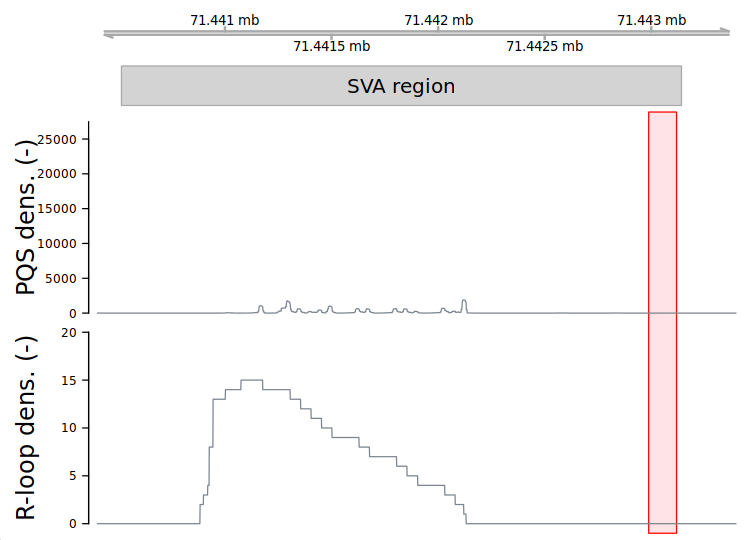

In [15]:
# plotting
options(repr.plot.width = 6.25, repr.plot.height = 4.5)

plots = list()
plots[["chrX:71440000-71444000:-"]] = plot_gviz(genome = xdp$genome,
                                                data = preds$`chrX:71440000-71444000:+`,
                                                plot_region = "chrX:71440400-71443400:-",
                                                highlight_region = "chrX:71442990-71443120:+",
                                                annot_region = "chrX:71440515-71443141:-",
                                                annot_text = "SVA region",
                                                plot_seq = F)

In [16]:
pdf(file = "chrX_71440400_71443400_minus.pdf", width = 6.5, height = 4.5)
plot_gviz(genome = xdp$genome,
          data = preds$`chrX:71440000-71444000:+`,
          plot_region = "chrX:71440400-71443400:-",
          highlight_region = "chrX:71442990-71443120:+",
          annot_region = "chrX:71440515-71443141:-",
          annot_text = "SVA region",
          plot_seq = F)
dev.off()

$Axis
Genome axis 'Axis'

[[2]]
AnnotationTrack ''
| genome: NA
| active chromosome: chrX
| annotation features: 1

$`PQS dens. (-)`
DataTrack 'PQS dens. (-)'
| genome: hg38
| active chromosome: chrX
| positions: 3000
| samples:1
| strand: - 

$`R-loop dens. (-)`
DataTrack 'R-loop dens. (-)'
| genome: hg38
| active chromosome: chrX
| positions: 3001
| samples:1
| strand: * 

$titles
An object of class "ImageMap"
Slot "coords":
                 x1    y1       x2    y2
Axis              6   6.0 52.04566  37.2
NA                6  37.2 52.04566  68.4
PQS dens. (-)     6  68.4 52.04566 193.2
R-loop dens. (-)  6 193.2 52.04566 318.0

Slot "tags":
$title
              Axis                 NA      PQS dens. (-)   R-loop dens. (-) 
            "Axis"               "NA"    "PQS dens. (-)" "R-loop dens. (-)" 




png 
  2

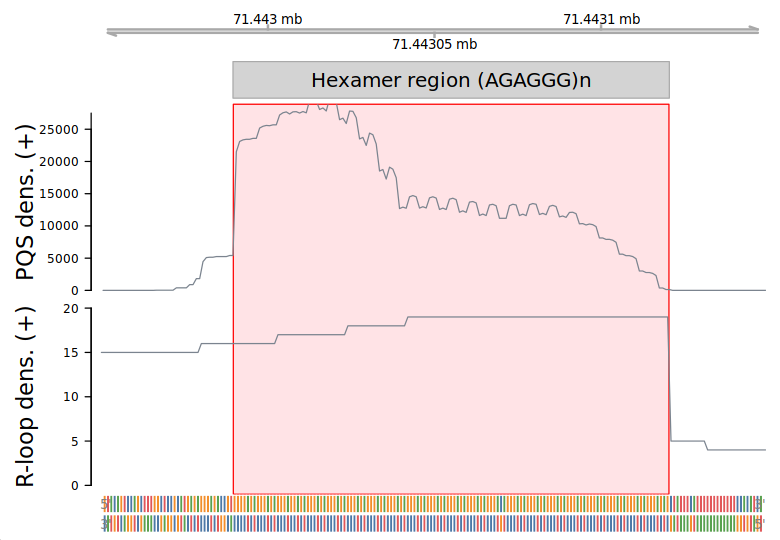

In [17]:
options(repr.plot.width = 6.5, repr.plot.height = 4.5)
plots[["chrX:71442950-71443150:+"]] = plot_gviz(genome = xdp$genome,
                                                data = preds$`chrX:71440000-71444000:+`,
                                                plot_region = "chrX:71442950-71443150:+",
                                                highlight_region = "chrX:71442990-71443120:+",
                                                annot_region = "chrX:71442990-71443120:+", 
                                                annot_text = "Hexamer region (AGAGGG)n",
                                                plot_seq = T)

In [18]:
pdf(file = "chrX_71442950_71443150_plus.pdf", width = 6.5, height = 4.5)
plot_gviz(genome = xdp$genome,
          data = preds$`chrX:71440000-71444000:+`,
          plot_region = "chrX:71442950-71443150:+",
          highlight_region = "chrX:71442990-71443120:+",
          annot_region = "chrX:71442990-71443120:+", 
          annot_text = "Hexamer region (AGAGGG)n",
          plot_seq = T)
dev.off()

$Axis
Genome axis 'Axis'

[[2]]
AnnotationTrack ''
| genome: NA
| active chromosome: chrX
| annotation features: 1

$`PQS dens. (+)`
DataTrack 'PQS dens. (+)'
| genome: hg38
| active chromosome: chrX
| positions: 200
| samples:1
| strand: + 

$`R-loop dens. (+)`
DataTrack 'R-loop dens. (+)'
| genome: hg38
| active chromosome: chrX
| positions: 201
| samples:1
| strand: * 

$SequenceTrack
Sequence track 'SequenceTrack':
| genome: NA
| chromosomes: 194
| active chromosome: chrX (156043522 nucleotides)
Call seqnames() to list all available chromosomes
Call chromosome()<- to change the active chromosome

$SequenceTrack
Sequence track 'SequenceTrack':
| genome: NA
| chromosomes: 194
| active chromosome: chrX (156043522 nucleotides)
Call seqnames() to list all available chromosomes
Call chromosome()<- to change the active chromosome

$titles
An object of class "ImageMap"
Slot "coords":
                 x1        y1       x2        y2
Axis              6   6.00000 51.50847  34.88889
NA       

png 
  2

## SVA D (TAF1 intron 32)

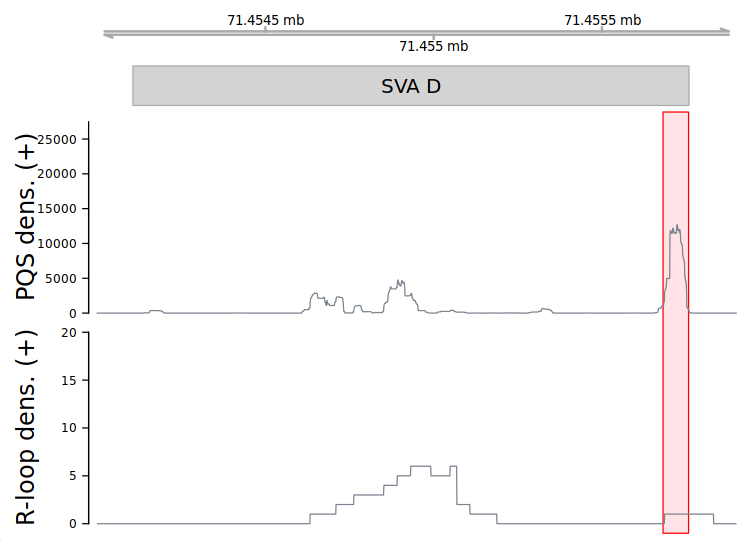

In [19]:
options(repr.plot.width = 6.25, repr.plot.height = 4.5)
plots[["chrX:71453000-71457000:+"]] = plot_gviz(genome = xdp$genome,
                                                data = preds$`chrX:71453000-71457000:+`,
                                                plot_region = "chrX:71454000-71455900:+",
                                                highlight_region = "chrX:71455683-71455758:+",
                                                annot_region = "chrX:71454107-71455758:+", 
                                                annot_text = "SVA D",
                                                plot_seq = F)

In [20]:
pdf(file = "chrX_71454000_71455900_plus.pdf", width = 6.5, height = 4.5)
plot_gviz(genome = xdp$genome,
          data = preds$`chrX:71453000-71457000:+`,
          plot_region = "chrX:71454000-71455900:+",
          highlight_region = "chrX:71455683-71455758:+",
         annot_region = "chrX:71454107-71455758:+", 
          annot_text = "SVA D",
          plot_seq = F)
dev.off()

$Axis
Genome axis 'Axis'

[[2]]
AnnotationTrack ''
| genome: NA
| active chromosome: chrX
| annotation features: 1

$`PQS dens. (+)`
DataTrack 'PQS dens. (+)'
| genome: hg38
| active chromosome: chrX
| positions: 1900
| samples:1
| strand: + 

$`R-loop dens. (+)`
DataTrack 'R-loop dens. (+)'
| genome: hg38
| active chromosome: chrX
| positions: 1901
| samples:1
| strand: * 

$titles
An object of class "ImageMap"
Slot "coords":
                 x1    y1       x2    y2
Axis              6   6.0 52.04566  37.2
NA                6  37.2 52.04566  68.4
PQS dens. (+)     6  68.4 52.04566 193.2
R-loop dens. (+)  6 193.2 52.04566 318.0

Slot "tags":
$title
              Axis                 NA      PQS dens. (+)   R-loop dens. (+) 
            "Axis"               "NA"    "PQS dens. (+)" "R-loop dens. (+)" 




png 
  2

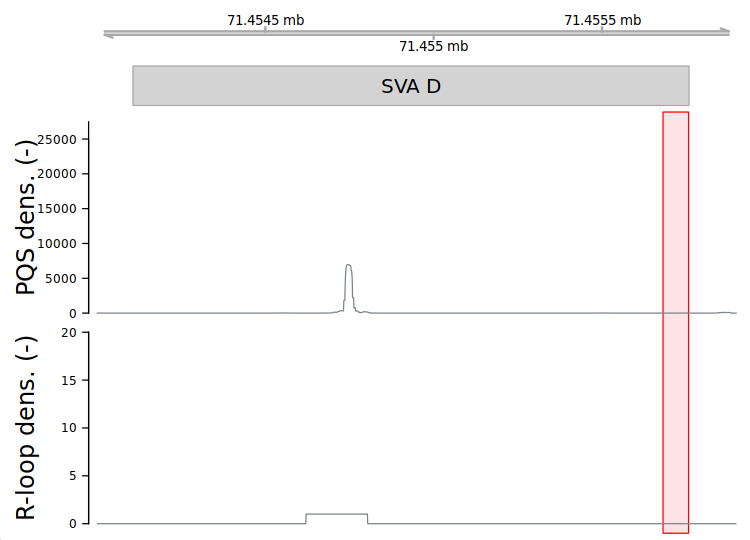

In [21]:
options(repr.plot.width = 6.25, repr.plot.height = 4.5)
plots[["chrX:71453000-71457000:-"]] = plot_gviz(genome = xdp$genome,
                                                data = preds$`chrX:71453000-71457000:+`,
                                                plot_region = "chrX:71454000-71455900:-",
                                                highlight_region = "chrX:71455683-71455758:+",
                                                annot_region = "chrX:71454107-71455758:+", 
                                                annot_text = "SVA D",
                                                plot_seq = F)

In [22]:
pdf(file = "chrX_71454000_71455900_minus.pdf", width = 6.5, height = 4.5)
plot_gviz(genome = xdp$genome,
          data = preds$`chrX:71453000-71457000:+`,
          plot_region = "chrX:71454000-71455900:-",
          highlight_region = "chrX:71455683-71455758:+",
          annot_region = "chrX:71454107-71455758:+", 
          annot_text = "SVA D",
          plot_seq = F)
dev.off()

$Axis
Genome axis 'Axis'

[[2]]
AnnotationTrack ''
| genome: NA
| active chromosome: chrX
| annotation features: 1

$`PQS dens. (-)`
DataTrack 'PQS dens. (-)'
| genome: hg38
| active chromosome: chrX
| positions: 1900
| samples:1
| strand: - 

$`R-loop dens. (-)`
DataTrack 'R-loop dens. (-)'
| genome: hg38
| active chromosome: chrX
| positions: 1901
| samples:1
| strand: * 

$titles
An object of class "ImageMap"
Slot "coords":
                 x1    y1       x2    y2
Axis              6   6.0 52.04566  37.2
NA                6  37.2 52.04566  68.4
PQS dens. (-)     6  68.4 52.04566 193.2
R-loop dens. (-)  6 193.2 52.04566 318.0

Slot "tags":
$title
              Axis                 NA      PQS dens. (-)   R-loop dens. (-) 
            "Axis"               "NA"    "PQS dens. (-)" "R-loop dens. (-)" 




png 
  2

In [23]:
# for(region in rois){
#     print(region)
#     plots[[region]] = plot_gviz(genome = xdp$genome,
#                                 data = preds[[region]],
#                                 plot_region = region)
# }

# Session Info

In [24]:
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Arch Linux

Matrix products: default
BLAS/LAPACK: /ceph/users/alorenzetti/conda/shared_envs/xdp_g4_pred_qvm2_env_r_python27/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] plyranges_1.18.0     BSgenome_1.66.1      rtracklayer_1.58.0  
 [4] Gviz_1.42.0          GenomicRanges_1.50.0 pqsfinder_2.14.0    
 [7] Biostrings_2.66.0    GenomeInfoDb_1.34.1  XVector_0.38.0      
[10] IRanges_2.32.0       S4Vectors_0.36.0    